# Instacart: Analysis and Forecasting

by [Raul Maldonado](https://www.linkedin.com/in/raulm8)


**STILL IN DEVELOPMENT**

![InstaCart Logo](https://bloximages.chicago2.vip.townnews.com/pinalcentral.com/content/tncms/assets/v3/editorial/e/4c/e4cb9197-ddce-59e1-93c7-2868e145c705/5b858c3f5e8de.image.jpg?resize=400%2C212)

## 1. Introduction

**Background**:

Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.


From the Instacart Kaggle competition, the organization challenged the Kaggle community  to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. 


### Import

In [67]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

plt.rcParams["axes.grid"] = False

import seaborn as sns

# Personal information via Localfile in
# the Resources/Admin folder.
import sys
sys.path.append("../Resources/Admin")
path = os.path.join('..','Resources','Data','RawData')

In [58]:
aislesDf = pd.read_csv(f'{path}/aisles.csv')
departmentsDf = pd.read_csv(f'{path}/departments.csv')
productsDf = pd.read_csv(f'{path}/products.csv')
ordersDf = pd.read_csv(f'{path}/orders.csv')
order_products_prior = pd.read_csv(f'{path}/order_products__prior.csv')
order_products_train = pd.read_csv(f'{path}/order_products__train.csv')

In [107]:
sampleSubmission_df = pd.read_csv(f'{path}/sample_submission.csv')

In [111]:
sampleSubmission_df.head(1)

,order_id,products
0,17,39276 29259


In [59]:
ordersDf_prior = ordersDf[ordersDf['eval_set']=='prior']

## 2. Analysis

### Preliminary EDA

We explore the various data of orders and product related characteristics to find patterns and habits from users purchases. This analysis alllows us to go more in-depth into finding potential discoverable insights in determining re-order classification for future purchases

**Preliminary EDA thoughts:**
* What are the top products ordered from users?
* What is the average basket of each order?
* What is the ranking of users total orders in dataset?
  * What is the average number of orders?
* What is the timeline for this dataset?
* What is the average basket price for each order?
* What is the total spend from users?
* Is there any noticeable geographical information to segment from?
* Can we identify the popular aisles?

What determines re-order? Type of product? Common essentials from specific aisles or departments? 

Does having a specific time of the day impact the re-ordering probability?

Since this is more of re-ordering probability (yes or no), can we have a supervised classification algorithm implemented for this project? There isn't a clearly defined structure of features, so curious about decision tree or random forest implementation.


#### What is our Average Amount of Orders?

In [78]:
numOrders_perUser = ordersDf[['order_id','user_id']].groupby('user_id').count() \
                          .sort_values('order_id',ascending=False)
numOrders_perUser.columns = ['Order Count']

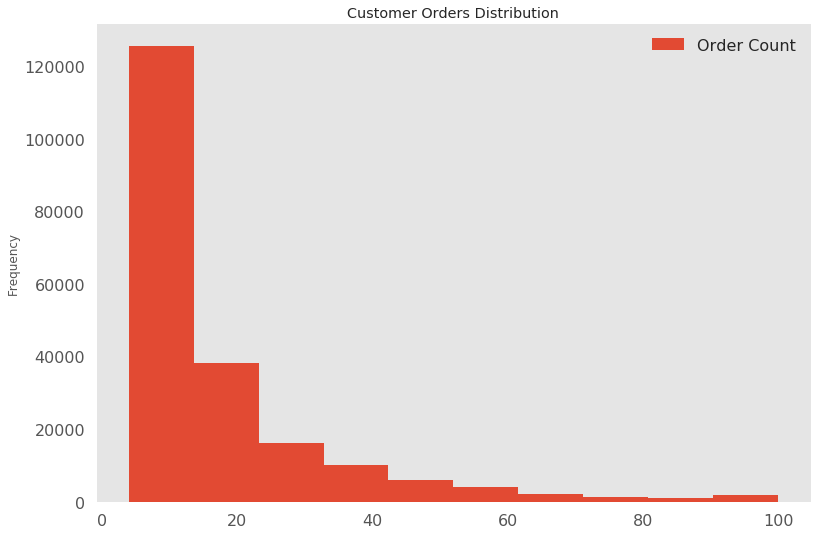

         Order Count
count  206209.000000
mean       16.590367
std        16.654774
min         4.000000
25%         6.000000
50%        10.000000
75%        20.000000
max       100.000000

Average Order Size: 16


In [79]:
numOrders_perUser.plot(kind='hist')
plt.title('Customer Orders Distribution')
plt.show()


ordersUsersSummary = numOrders_perUser.describe()
print(ordersUsersSummary)
print(f'''\nAverage # Customer Orders: {int(ordersUsersSummary.loc['mean'])}''')

In [76]:
basketSize_df = order_products_prior[['order_id','product_id']].groupby('order_id').count() \
                          .sort_values('product_id', ascending=False)
basketSize_df.columns = ['Basket Size']

In [80]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


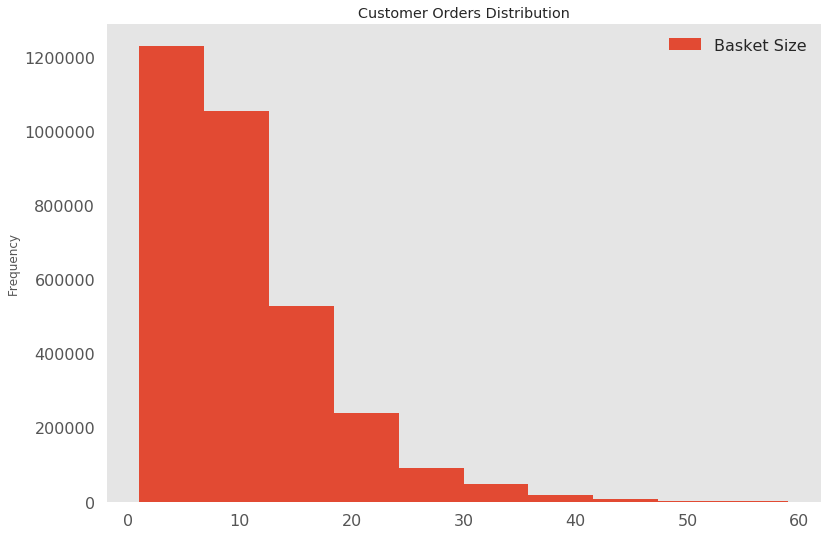

        Basket Size
count  3.214874e+06
mean   1.008888e+01
std    7.525398e+00
min    1.000000e+00
25%    5.000000e+00
50%    8.000000e+00
75%    1.400000e+01
max    1.450000e+02

Average Order Size: 10


In [83]:
#Plot Order sizes with less than 60 items (visually remove outliers) 
basketSize_df[basketSize_df['Basket Size']<60].plot(kind='hist')
plt.title('Customer Orders Distribution')
plt.show()


ordersBasketSummary = basketSize_df.describe()
print(ordersBasketSummary)
print(f'''\nAverage Order Size: {int(ordersBasketSummary.loc['mean'])}''')

#### What were the overall top 15 Purchased Products?

In [8]:
ordersJoinedProductNames_df = order_products_prior.merge(productsDf,on=[ \
                                  'product_id','product_id'], how='inner')

In [9]:
ordersJoinedProductNames_byProduct = ordersJoinedProductNames_df[ \
                                     ['product_name','order_id']].groupby('product_name') \
                                         .count().sort_values('order_id',ascending=False)
ordersJoinedProductNames_byProduct.columns = ['Product Count']

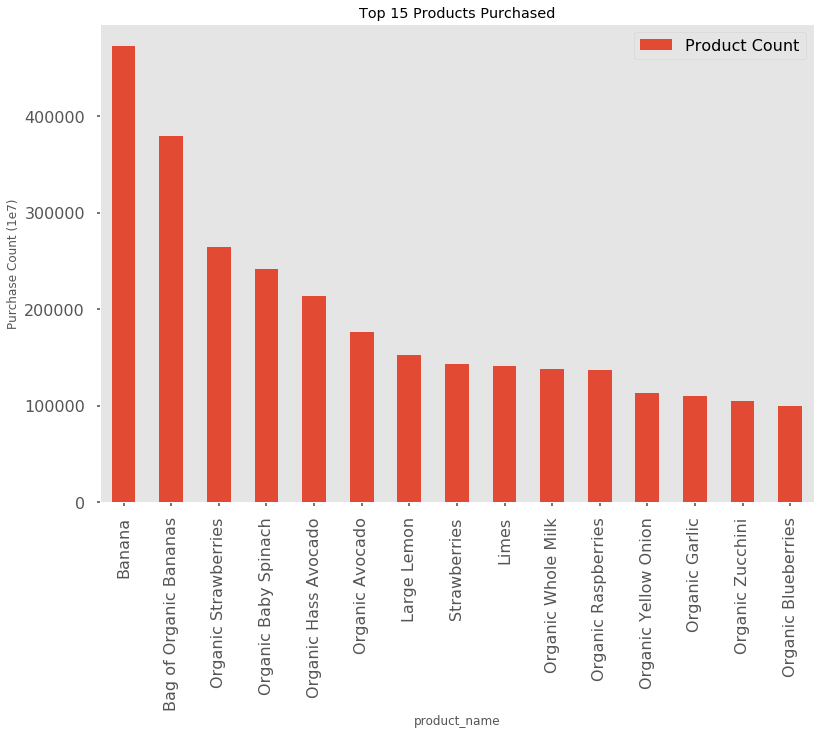

                        Product Count  Product Ratio
product_name                                        
Banana                         472565       0.014570
Bag of Organic Bananas         379450       0.011699
Organic Strawberries           264683       0.008161
Organic Baby Spinach           241921       0.007459
Organic Hass Avocado           213584       0.006585
Organic Avocado                176815       0.005451
Large Lemon                    152657       0.004707
Strawberries                   142951       0.004407
Limes                          140627       0.004336
Organic Whole Milk             137905       0.004252


In [10]:
ordersJoinedProductNames_byProduct[:15].plot(kind='bar')
plt.title('Top 15 Products Purchased')
plt.ylabel('Purchase Count (1e7)')
plt.show()


ordersJoinedProductNames_byProduct['Product Ratio'] = ordersJoinedProductNames_byProduct['Product Count'] /\
                                                    ordersJoinedProductNames_byProduct['Product Count'].sum()
print(ordersJoinedProductNames_byProduct[:10])

Top products purchased by users were more towards essential produce or other essentials ranging from 137,000-470,00, in particular fruits/vegetables. 

#### Top 15 Purchased Products by Aisle

In [11]:
orders_JoinProductsAndDepartments = order_products_prior.merge( \
        productsDf, on=['product_id','product_id'],how='inner') \
        .merge(departmentsDf, on =['department_id','department_id'], \
        how='left')

In [12]:
orders_JoinProductsAndAisles_grouped = orders_JoinProductsAndDepartments[ \
        ['order_id','aisle_id']] \
        .groupby(['aisle_id']).count().reset_index( \
        'aisle_id',drop=False).sort_values('order_id',ascending=False)
orders_JoinProductsAndAisles_grouped.set_index('aisle_id',inplace = True)
orders_JoinProductsAndAisles_grouped.columns = ['Aisle Count']

In [13]:
ordersAisleDF = orders_JoinProductsAndAisles_grouped.merge( \
                    aislesDf,on=['aisle_id','aisle_id'],how='inner')[['aisle','Aisle Count']]

In [14]:
ordersAisleDF.set_index('aisle',inplace=True)

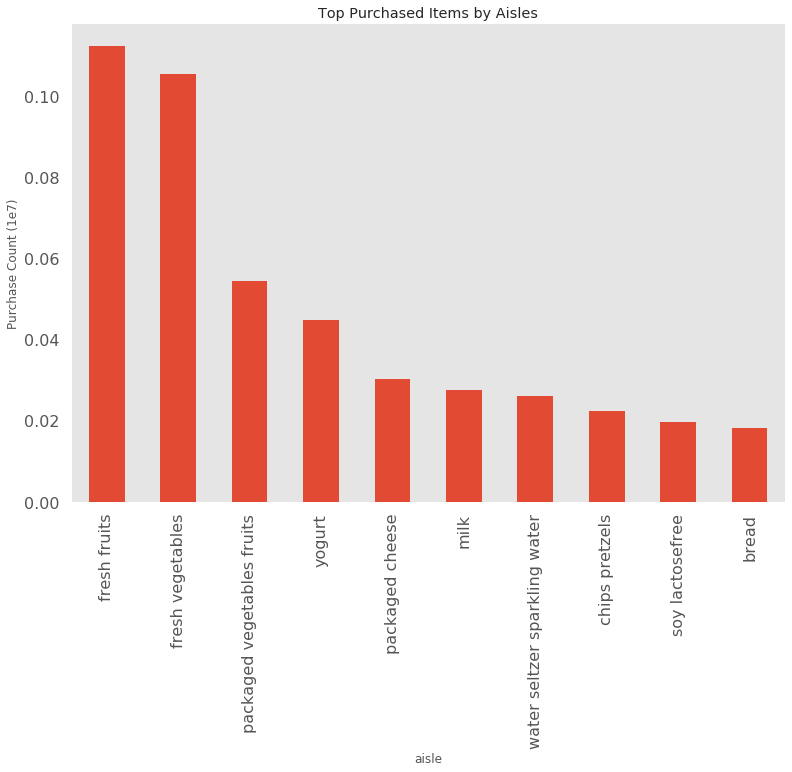

                               Aisle Count  Aisle Total (Ratio)
aisle                                                          
fresh fruits                       3642188             0.112294
fresh vegetables                   3418021             0.105382
packaged vegetables fruits         1765313             0.054427
yogurt                             1452343             0.044778
packaged cheese                     979763             0.030207
milk                                891015             0.027471
water seltzer sparkling water       841533             0.025946
chips pretzels                      722470             0.022275
soy lactosefree                     638253             0.019678
bread                               584834             0.018031


In [87]:
ordersAisleDF['Aisle Total (Ratio)'] = ordersAisleDF['Aisle Count'] / ordersAisleDF['Aisle Count'].sum() 

ordersAisleDF['Aisle Total (Ratio)'][:10].plot(kind='bar')
plt.title('Top Purchased Items by Aisles')
plt.ylabel('Purchase Count (1e7)')
plt.show()


print(ordersAisleDF[:10])



We observe that our Instacart orders mostly comprise of fruits, vegetables, and dairy related items.

#### Top Department-related orders

In [16]:
orders_JoinProductsAndDepartments = order_products_prior.merge(productsDf,on=['product_id','product_id'],how='inner') \
                    .merge(departmentsDf, on =['department_id','department_id'], \
                           how='left')

In [17]:
orders_JoinProductsAndDepartments_grouped = orders_JoinProductsAndDepartments[['order_id','department_id','department']] \
        .groupby(['department_id','department']).count().reset_index( \
        'department_id',drop=True).sort_values('order_id',ascending=False)
orders_JoinProductsAndDepartments_grouped.columns = ['Department Count']

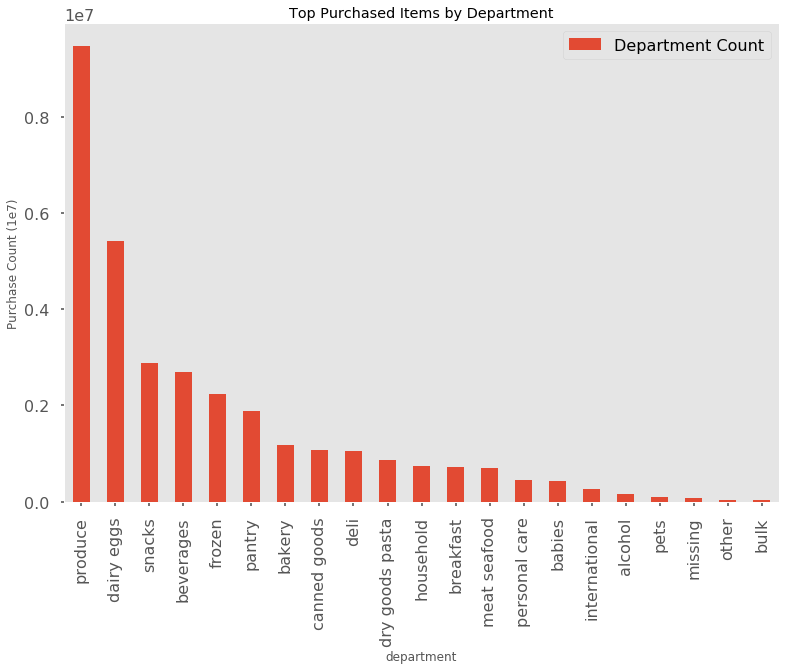

                 Department Count  Department Total (Ratio)
department                                                 
produce                   9479291                  0.292260
dairy eggs                5414016                  0.166922
snacks                    2887550                  0.089027
beverages                 2690129                  0.082940
frozen                    2236432                  0.068952
pantry                    1875577                  0.057827
bakery                    1176787                  0.036282
canned goods              1068058                  0.032930
deli                      1051249                  0.032411
dry goods pasta            866627                  0.026719


In [18]:
orders_JoinProductsAndDepartments_grouped.plot(kind='bar')
plt.title('Top Purchased Items by Department')
plt.ylabel('Purchase Count (1e7)')
plt.show()

orders_JoinProductsAndDepartments_grouped['Department Total (Ratio)'] = orders_JoinProductsAndDepartments_grouped['Department Count']/\
                                            orders_JoinProductsAndDepartments_grouped['Department Count'].sum()
print(orders_JoinProductsAndDepartments_grouped[:10])

**Thoughts so far**

Focusing on a product-centric analysis through segementation of Products, Aisles, and Departments, we found the following:

* Top products purchased by users were more towards essential produce or other essentials ranging from 137,000-470,00, in particular fruits/vegetables. 

* For Aisle Segments in top products, we see:
    * Fresh Fruits (Ratio): ~11%
    * Fresh Vegetables (Ratio): ~10.5%
    * Packaged Vegetable Fruits (Ratio): ~5% 
    * Yogurt (Ratio): ~4.4 %
    
* For Department breakdown in top products, we see
    * produce : ~29.22%
    * dairy eggs :  ~16.7%
    * snacks: ~8.90%
    * beverages: ~8.3%
    * Frozen: 6.9%

It would be insightsful to determine what products would and are going to be top purchases from signals like pricing or "essential" food rating. (i.e. More analysis could be carried in here for evaluation of association to predicting re-ordering likelihood)


For more exploration, what other factors could be associated with a good chance in a product's probability for re-ordering? If you notice, we have time-series features for time-series segmentation analysis by using day of the week (DoW) or Time of Day.

Moreover, can we gauge the significant re-order ratios for particular columns for time related segmentations?

#### Event/Time Segmentation

In [19]:
ordersAndProducts_TimeDf = order_products_prior.merge( \
        ordersDf_prior, how='left', on =['order_id','order_id'])\
        .merge(productsDf, how='left', on =['product_id','product_id'])


In [20]:
import sys
sys.path.append('../DataEngineering/DataTransformation-Functions/')

from data_transformation_functions import hour_of_day_cut

In [21]:
ordersAndProducts_TimeDf['order_hod_cat'] = ordersAndProducts_TimeDf\
        .order_hour_of_day.transform(hour_of_day_cut)

##### Orders and Day of the Week

In [22]:
orders_timeDf_nonDuplicates = ordersAndProducts_TimeDf.drop_duplicates('order_id')[[\
        'order_id','order_dow']]
orders_timeDf_nonDuplicates.reset_index(inplace=True,drop = True)

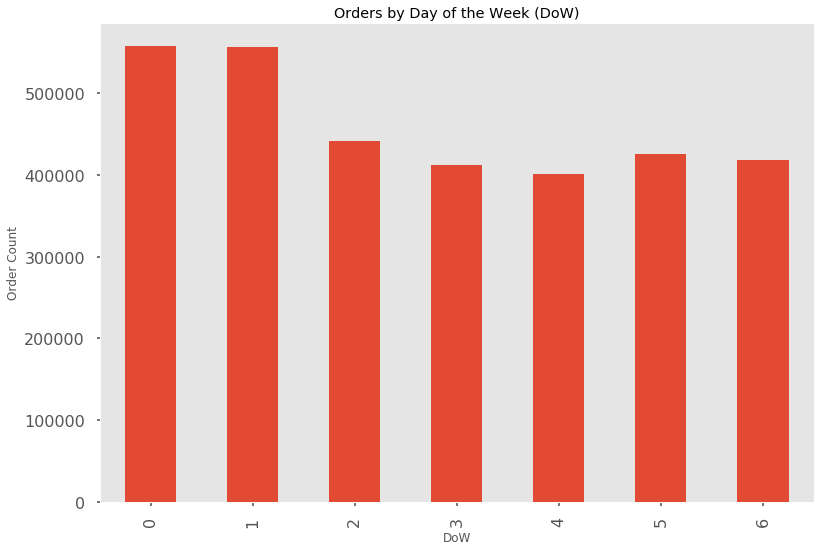

In [23]:
orders_timeDf_nonDuplicates.groupby(['order_dow'])\
        .count()\
        .plot(kind='bar',legend =False)
plt.title('Orders by Day of the Week (DoW)')
plt.ylabel('Order Count')
plt.xlabel('DoW')
plt.show()

##### Orders and Time of Day

In [24]:
orders_timeDf_nonDuplicates_ohod = ordersAndProducts_TimeDf.drop_duplicates('order_id')[[\
        'order_id','order_hod_cat']]
orders_timeDf_nonDuplicates_ohod.reset_index(inplace=True,drop = True)

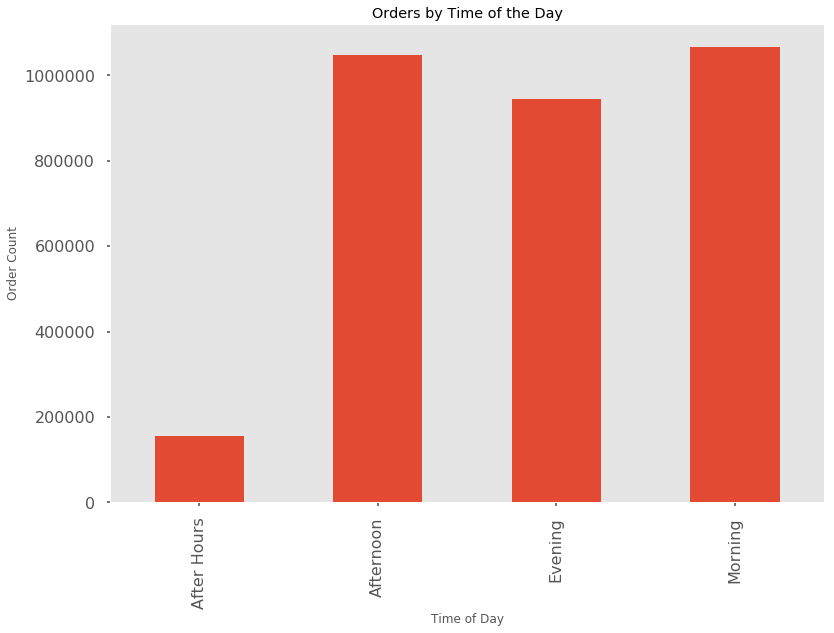

In [25]:
orders_timeDf_nonDuplicates_ohod.groupby(['order_hod_cat'])\
        .count()\
        .plot(kind='bar',legend =False)
plt.title('Orders by Time of the Day')
plt.ylabel('Order Count')
plt.xlabel('Time of Day')
plt.show()

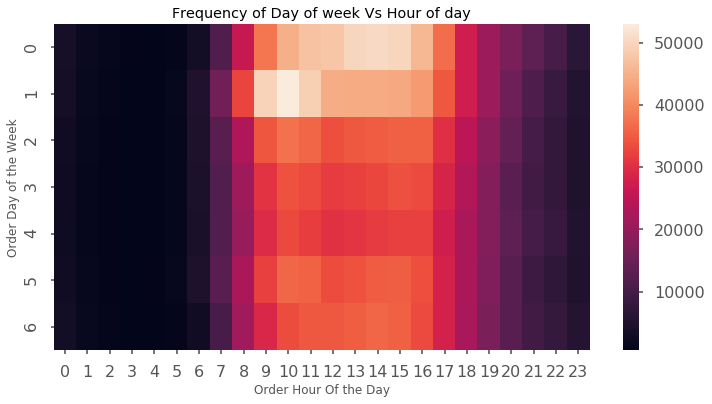

In [26]:
ordersGroupedDF = ordersDf[ordersDf['eval_set']=='prior'].groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
ordersGroupedDF = ordersGroupedDF.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(ordersGroupedDF)
plt.title("Frequency of Day of week Vs Hour of day")
plt.ylabel('Order Day of the Week')
plt.xlabel('Order Hour Of the Day')
plt.show()

##### Top Products by Time of the Day

In [27]:
orders_timeDf_ohod = ordersAndProducts_TimeDf[[\
        'order_id','order_hod_cat','product_name']]
orders_timeDf_ohod.reset_index(inplace=True,drop = True)

In [28]:
orders_timeDf_grouped = orders_timeDf_ohod.groupby(['order_hod_cat','product_name'])\
        .count().sort_values(['order_hod_cat','order_id'],ascending=False)
orders_timeDf_grouped.reset_index(inplace=True)
orders_timeDf_grouped.head()

,order_hod_cat,product_name,order_id
0,Morning,Banana,163891
1,Morning,Bag of Organic Bananas,130488
2,Morning,Organic Strawberries,89015
3,Morning,Organic Baby Spinach,79550
4,Morning,Organic Hass Avocado,70312


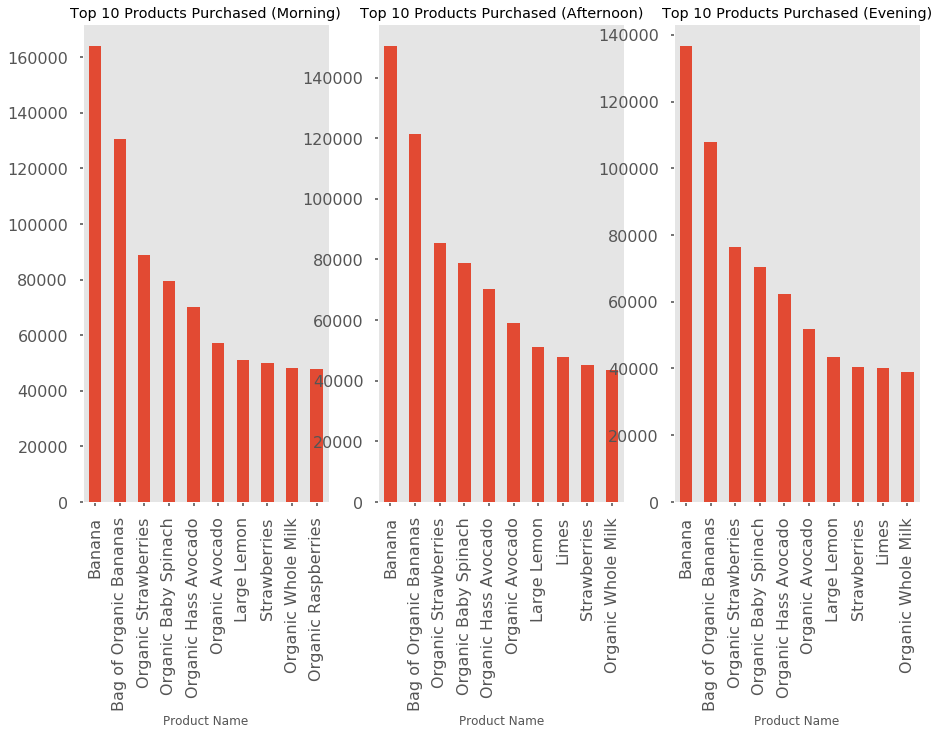

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(15)

#Morning plot
orders_timeDf_grouped[orders_timeDf_grouped['order_hod_cat']=='Morning'][:10].set_index('product_name')\
        .plot(kind='bar',legend =False, ax = ax[0])
ax[0].set_xlabel('Product Name')
ax[0].set_title('Top 10 Products Purchased (Morning)')

# Afternoon Plot
orders_timeDf_grouped[orders_timeDf_grouped['order_hod_cat']=='Afternoon'][:10].set_index('product_name')\
        .plot(kind='bar',legend =False, ax = ax[1])
ax[1].set_xlabel('Product Name')
ax[1].set_title('Top 10 Products Purchased (Afternoon)')

# Evening Plot
orders_timeDf_grouped[orders_timeDf_grouped['order_hod_cat']=='Evening'][:10].set_index('product_name')\
        .plot(kind='bar',legend =False, ax = ax[2])
ax[2].set_xlabel('Product Name')
ax[2].set_title('Top 10 Products Purchased (Evening)')


plt.show()

##### Top Products by Day of the Week

In [30]:
orders_timeDf_dow = ordersAndProducts_TimeDf[[\
        'order_id','order_dow','product_name']]
orders_timeDf_dow.reset_index(inplace=True,drop = True)

In [31]:
orders_timeDf_groupedDoW = orders_timeDf_dow.groupby(['order_dow','product_name'])\
        .count().sort_values(['order_dow','order_id'],ascending=False)
orders_timeDf_groupedDoW.reset_index(inplace=True)
orders_timeDf_groupedDoW.head()

,order_dow,product_name,order_id
0,6,Banana,63314
1,6,Bag of Organic Bananas,49247
2,6,Organic Strawberries,36723
3,6,Organic Baby Spinach,35124
4,6,Organic Hass Avocado,28513


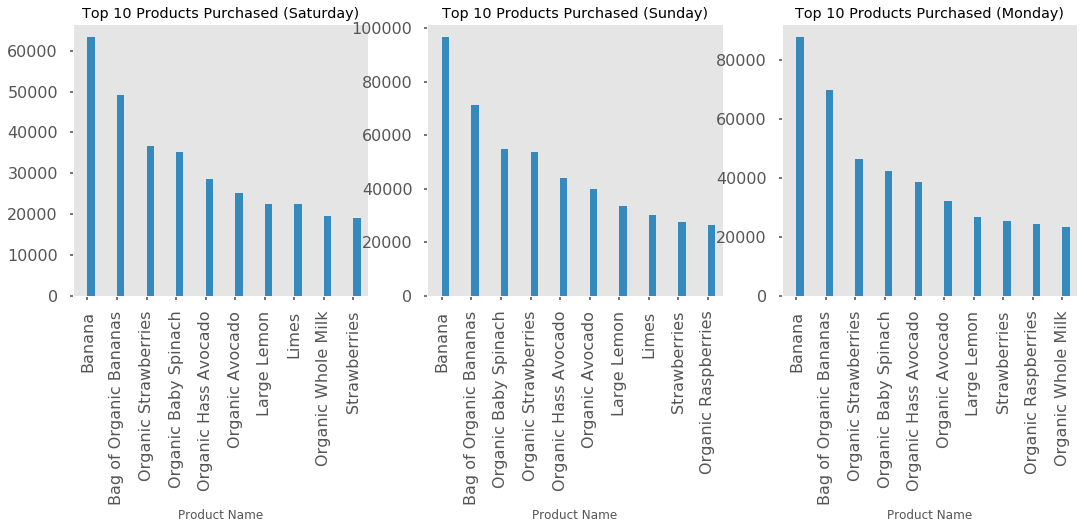

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(18)
fig.set_figheight(5)

#Morning plot
orders_timeDf_groupedDoW[orders_timeDf_groupedDoW['order_dow']==6][:10].set_index('product_name')\
        .plot(kind='bar',legend =False, ax = ax[0])
ax[0].set_xlabel('Product Name')
ax[0].set_title('Top 10 Products Purchased (Saturday)')

# Afternoon Plot
orders_timeDf_groupedDoW[orders_timeDf_groupedDoW['order_dow']==0][:10].set_index('product_name')\
        .plot(kind='bar',legend =False, ax = ax[1])
ax[1].set_xlabel('Product Name')
ax[1].set_title('Top 10 Products Purchased (Sunday)')

# Evening Plot
orders_timeDf_groupedDoW[orders_timeDf_groupedDoW['order_dow']==1][:10].set_index('product_name')\
        .plot(kind='bar',legend =False, ax = ax[2])
ax[2].set_xlabel('Product Name')
ax[2].set_title('Top 10 Products Purchased (Monday)')


plt.show()

**Thoughts so Far:**

There aren't major significant differences from the above segementations. We wanted to understand the differences in popular product purchases by either overall, store location, or time of purchases, we did not find wide variations in popularity. 

In particular, we found that most purchases were made between 9am-4pm in the beginning of the week, and declined outside those timeframes (based on the time-distribution heatmap). Moreover, with segmentation, we were not able to find major changes in product purchases habits over timeframes (e.g. People are always bananas for bananas).

But rather, we should be focusing on re-ordered items and their potential characteristics against non-reordered values. This would allow us to get an understanding of what is more likely/predicted to be a re-ordered product.

### EDA (Part II)

Again, we scope into re-ordered products and attempt to idenfity what features to be considered in defining the probability of a product being re-purchased.

If I group by reordered, then I can get the distribution of products between ordered vs non-reordered.
    From that distribution, i want to identify re-order count between segements like the one we seen before....
            if i do that, is that a waste of time?
        
        
        - Users and their Reorder Habits?
        - By reorder habits only?
        - Re-order habits by time?
        -Reorder condition and getting distribution of products counts
        
        
Ratio of re-order throughout day. Ratio of re-order throughout week


If I want to buy something, then I buy it. Repeat that for every item I want in the store. Once more order is complete, I purchase the product.


I come back to the store. I will tend to go get the first item I usually get based on my own habits, If I am missing something, or I want something I liked from a prevoius purchase. 

In [33]:
ordersDf_prior = ordersDf[ordersDf['eval_set']=='prior']
orders_withProducts_priorDf = order_products_prior.merge(ordersDf_prior, \
                                                         how='left', on=['order_id','order_id'])\
                                                  .merge(productsDf, \
                                                         how='left',on=['product_id','product_id'])

#### ReOrders by Time Segmentation

In [34]:
orders_prior_grouped1_df = orders_withProducts_priorDf.groupby(by=['order_hour_of_day','reordered']).count()['product_id']
orders_prior_grouped1_df = orders_prior_grouped1_df.reset_index()


In [35]:
orders_prior_grouped1_df= orders_prior_grouped1_df.set_index(['order_hour_of_day','reordered'])

In [36]:
orders_prior_grouped1_df = orders_prior_grouped1_df/orders_prior_grouped1_df.groupby(level=[0]).transform('sum')
orders_prior_grouped1_df.columns = ['Total Count']

In [37]:
orders_prior_grouped1_df.reset_index(inplace=True)

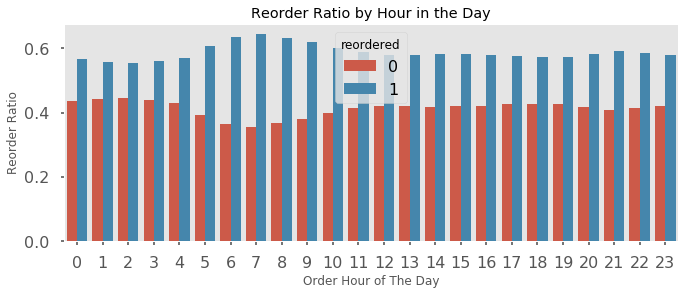

In [38]:
plt.figure(figsize=(11,4))

sns.barplot(x=orders_prior_grouped1_df['order_hour_of_day'],\
            y=orders_prior_grouped1_df['Total Count'],\
            hue=orders_prior_grouped1_df['reordered'])
plt.title('Reorder Ratio by Hour in the Day')
plt.ylabel('Reorder Ratio')
plt.xlabel('Order Hour of The Day')
plt.show()

In [39]:
orders_prior_grouped2_df = orders_withProducts_priorDf.groupby(by=['order_dow','reordered']).count()['product_id']
# orders_prior_grouped2_df = orders_prior_grouped2_df.reset_index()


In [40]:
orders_prior_grouped2_df = orders_prior_grouped2_df/orders_prior_grouped2_df.groupby(level=[0]).transform('sum')
orders_prior_grouped2_df=pd.DataFrame(orders_prior_grouped2_df)
# orders_prior_grouped2_df.set_index(['order_dow','reordered'],inplace=True)
orders_prior_grouped2_df.columns = ['Total Count']
orders_prior_grouped2_df.reset_index(inplace=True)

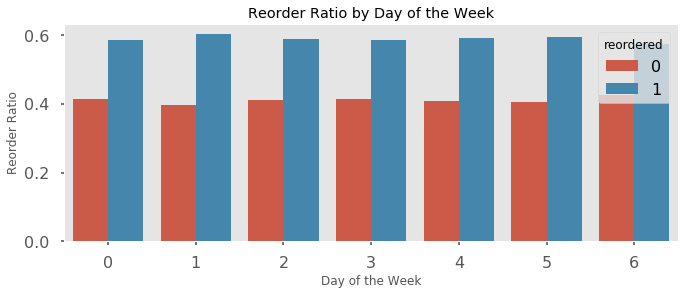

In [41]:
plt.figure(figsize=(11,4))

sns.barplot(x=orders_prior_grouped2_df['order_dow'],\
            y=orders_prior_grouped2_df['Total Count'],\
            hue=orders_prior_grouped1_df['reordered'])
plt.title('Reorder Ratio by Day of the Week')
plt.ylabel('Reorder Ratio')
plt.xlabel('Day of the Week')
plt.show()

#### Re-order Ratio by Product Location Segmentation (e.g. Aisle, Department)

When we shop at a grocery store or access an app, we tend to gravitate to the recommended or first visually attractive item, in consequence can have a higher probability of being re-orderd

In [42]:
orders_JoinProductsDepartments_reorderDf = orders_JoinProductsAndDepartments.groupby(\
        by=['department_id','department','reordered']).count()['product_id']
orders_JoinProductsDepartments_reorderDf = orders_JoinProductsDepartments_reorderDf.reset_index()


In [43]:
orders_JoinProductsDepartments_reorderDf= orders_JoinProductsDepartments_reorderDf.set_index(\
                                                ['department','reordered'])

In [44]:
orders_JoinProductsDepartments_reorderDf.drop(labels='department_id', axis=1, inplace = True)

In [45]:
orders_JoinProductsDepartments_reorderDf = orders_JoinProductsDepartments_reorderDf\
                            / orders_JoinProductsDepartments_reorderDf.groupby(\
                                level=[0]).transform('sum')
orders_JoinProductsDepartments_reorderDf.columns = ['Total Count']

In [46]:
orders_JoinProductsDepartments_reorderDf.reset_index(inplace=True)

In [47]:
orders_JoinProductsDepartments_reorderDf = orders_JoinProductsDepartments_reorderDf.sort_values(\
                                                'Total Count', ascending=True)

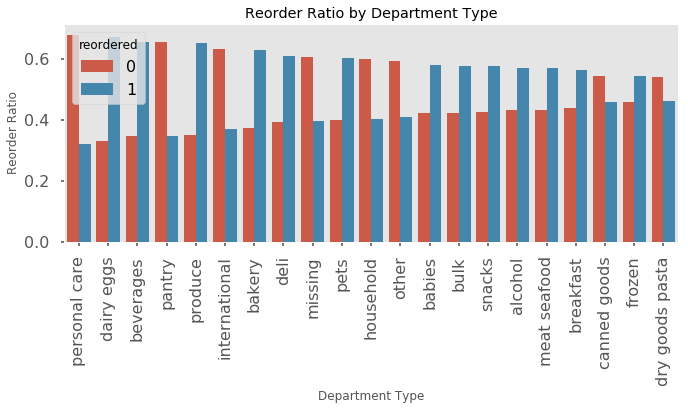

In [48]:
plt.figure(figsize=(11,4))

sns.barplot(x='department',\
            y='Total Count',\
            hue='reordered',\
            data=orders_JoinProductsDepartments_reorderDf)
plt.title('Reorder Ratio by Department Type')
plt.ylabel('Reorder Ratio')
plt.xlabel('Department Type')
plt.xticks(rotation=90)
plt.show()

In [49]:
orders_prodAisles_df = orders_JoinProductsAndDepartments.merge(\
                    aislesDf,on=['aisle_id','aisle_id'],how='inner')

In [50]:
orders_prodAisles_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,dairy eggs,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,dairy eggs,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,dairy eggs,eggs


In [51]:
orders_aisles_reorderDf = orders_prodAisles_df.groupby(\
        by=['aisle_id','aisle','reordered']).count()['product_id']
orders_aisles_reorderDf = orders_aisles_reorderDf.reset_index()
orders_aisles_reorderDf= orders_aisles_reorderDf.set_index(\
                                                ['aisle','reordered'])
orders_aisles_reorderDf.drop(labels='aisle_id', axis=1, inplace = True)
orders_aisles_reorderDf = orders_aisles_reorderDf\
                            / orders_aisles_reorderDf.groupby(\
                                level=[0]).transform('sum')
orders_aisles_reorderDf.columns = ['Total Count']

orders_aisles_reorderDf = orders_aisles_reorderDf.sort_values(\
                                                'Total Count', ascending=True)

In [52]:
orders_aisles_reorderDf.reset_index(inplace=True)

In [53]:
orders_aisles_reorderOnlyDf = orders_aisles_reorderOnlyDf = orders_aisles_reorderDf[orders_aisles_reorderDf['reordered']==1].sort_values('Total Count', ascending=False)

In [54]:
orders_aisles_reorderDf= orders_aisles_reorderDf.sort_values('Total Count', ascending=False)

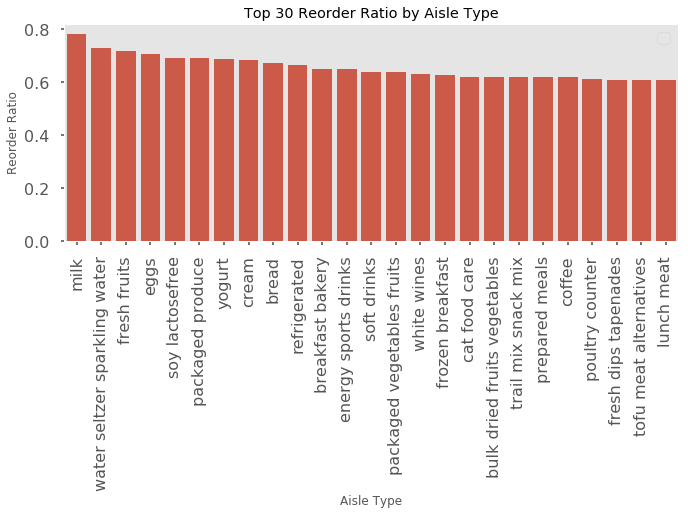

In [55]:
plt.figure(figsize=(11,4))

sns.barplot(x='aisle',\
            y='Total Count',\
            hue='reordered',\
            data=orders_aisles_reorderOnlyDf[:25])
plt.title('Top 30 Reorder Ratio by Aisle Type')
plt.ylabel('Reorder Ratio')
plt.legend('')
plt.xlabel('Aisle Type')
plt.xticks(rotation=90)
plt.show()

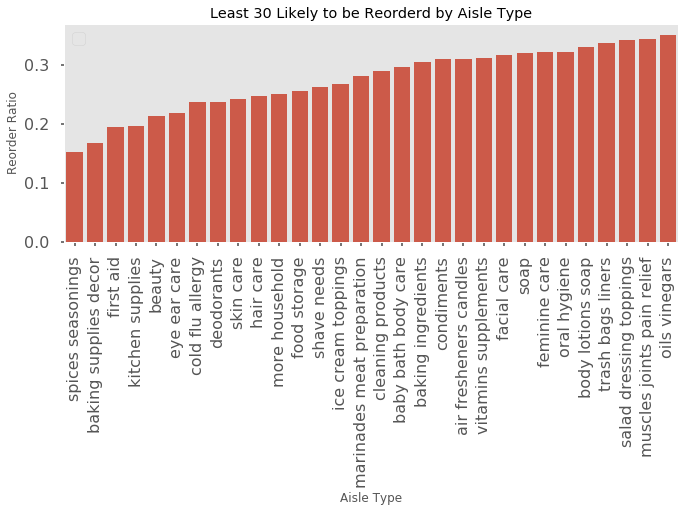

In [56]:
orders_aisles_reorderLeastLikelyDf = orders_aisles_reorderDf[orders_aisles_reorderDf[\
                                        'reordered']==1].sort_values(\
                                            'Total Count', ascending=True)
plt.figure(figsize=(11,4))

sns.barplot(x='aisle',\
            y='Total Count',\
            hue='reordered',\
            data=orders_aisles_reorderLeastLikelyDf[:30])
plt.title('Least 30 Likely to be Reorderd by Aisle Type')
plt.ylabel('Reorder Ratio')
plt.legend('')
plt.xlabel('Aisle Type')
plt.xticks(rotation=90)
plt.show()


#### Re-identifying Characteristics for determination of modeling


In [ ]:
# Average Number of orders was 16, and wasn't so mich therafters. This distribution was right skewed

# Average order size was 10, and still had right skewed distribution
### It was interesting to see that some number of orders had a larrrrrger basket than more
#########News article on how people are taking large bundles


# People were bananas for bananas



#ideas:
###get ranking of those items that were last in shopping cart list as likely to be re-ordered due to impulses

#fresh fruit and fresh vegetable were top in aisles--was this due to importance of nutrition, aisle placement in supermarkets, UI recommendations in app

#Department: Produce, dairy, snacks

#Orders typically happen beginning of week
# 9am-5pm Beginning of week when more frequent orders occur


# reorders occur slightly more 5% more in the early morning, 8am-10am (people don't have food in fridge)




#In forecasting, for some given amount of features, we want to determine for the next order, what the product would be

## 3. Forecasting

**Objective:** Predicting product items in the next cart.

Based on the sample data, we find that the information gathered in our prediction is a concatenated list of product ids per order.

Example:

| Order ID       | Products     |
| :------------- | ----------: |
|  123            |          9987 9912 |
| 124  | 9965 99123 12387 |

In [89]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [90]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()


In [91]:
ordersDf_train = ordersDf[ordersDf['eval_set']=='train']


In [92]:
reorder_df = order_products_train.merge(ordersDf_train,left_on='order_id',right_on='order_id',how='left')\
                    .merge(productsDf,on=['product_id','product_id'], how='left')
print("Data's Dimensions: ", reorder_df.shape)

Data's Dimensions:  (1384617, 13)


In [93]:
reorder_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [94]:
reorder_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id'],
      dtype='object')

In [95]:
#Preliminary Training to main training, by grabbing sample of 2000 data points
reorder_df = reorder_df.sample(n=2000,random_state=42)

features = reorder_df[['order_id','days_since_prior_order','order_hour_of_day',\
                       'aisle_id','department_id','reordered']]
                      
target= reorder_df['product_id']

In [96]:
model.fit(features,target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [97]:
model.score(features,target)

0.9995

In [100]:
reorder_df_prior_demo = order_products_prior.merge(ordersDf_prior,left_on='order_id',right_on='order_id',how='left')\
                    .merge(productsDf,on=['product_id','product_id'], how='left')
print("Data's Dimensions: ", reorder_df_prior_demo.shape)

reorder_df_prior_demo = reorder_df_prior_demo.sample(n=2000,random_state=42)


features_demo = reorder_df_prior_demo[['order_id','days_since_prior_order','order_hour_of_day',\
                       'aisle_id','department_id','reordered']]
                      
target_demo= reorder_df_prior_demo['product_id']

Data's Dimensions:  (32434489, 13)


In [101]:
features_demo[:10]

,order_id,days_since_prior_order,order_hour_of_day,aisle_id,department_id,reordered
29481110,3109255,8.0,19,104,13,0
2852353,301098,1.0,15,83,4,0
11194500,1181866,8.0,17,24,4,0
15909397,1678630,26.0,14,115,7,1
6101870,644090,30.0,19,75,17,0
5278828,557169,10.0,12,129,1,1
6983365,737337,8.0,13,24,4,1
13169449,1389978,16.0,20,45,19,1
4203220,443457,6.0,9,126,11,1
15630910,1649178,17.0,8,120,16,1


In [102]:
prediction_results = model.predict(reorder_df_prior_demo[['order_id','days_since_prior_order','order_dow','order_hour_of_day',\
                       'aisle_id','department_id']][:10])
prediction_results

array([ 9837, 47222, 42585, 41588,  9837, 41362, 41362,  9837, 41362,
        6867])

In [103]:
from sklearn.metrics import classification_report


In [104]:
reorder_df_prior_demo.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
29481110,3109255,34099,16,0,135284,prior,9,0,19,8.0,Crushed Red Chili Pepper,104,13
2852353,301098,41950,5,0,7293,prior,2,4,15,1.0,Organic Tomato Cluster,83,4
11194500,1181866,45066,8,0,111385,prior,2,1,17,8.0,Honeycrisp Apple,24,4
15909397,1678630,8859,2,1,147365,prior,7,0,14,26.0,Natural Spring Water,115,7
6101870,644090,24781,2,0,99290,prior,7,0,19,30.0,"PODS Laundry Detergent, Ocean Mist Designed fo...",75,17


In [115]:
productsDf.loc[productsDf['product_id'].isin(prediction_results)][['product_id','product_name']]

,product_id,product_name
3797,3798,Pink Lady Apples
5604,5605,Sesame Seed
8173,8174,Organic Navel Orange
15289,15290,Orange Bell Pepper
23636,23637,Maple & Brown Sugar High Fiber Instant Oatmeal
33197,33198,Sparkling Natural Mineral Water
33456,33457,Chicken Breast Nuggets
37946,37947,Organic Peach Lowfat Yogurt
39957,39958,Organics Gummy Bears
46021,46022,Baked Whole Grain Wheat Original Crackers Thin...


(TODO): How should I continue? 
1. Feature Selection
2. Feature Engineering (Ratios)

## Resources

[Starting with Postgres](https://www.codementor.io/engineerapart/getting-started-with-postgresql-on-mac-osx-are8jcopb)

[Postgres via SQLAlchemy](https://www.compose.com/articles/using-postgresql-through-sqlalchemy/)